# Google News Extraction and Topic Modelling

Use of googlesearch to obtain urls based on Google query search. Download sentences from urls with Article / newspaper3k and preprocessing to remove special characters. Further removal of similar sentences by looking at cosine similarity. Obtain a large list of sentences on the query search.

In [ ]:
!pip install transformers

In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install newspaper3k

In [ ]:
!pip install BERTopic

In [ ]:
!pip install pygooglenews

In [1]:
from sentence_transformers import SentenceTransformer, util
from googlesearch import search
from newspaper import Article
from bertopic import BERTopic
from nltk import tokenize
from tqdm import tqdm
import nltk
import re

We use pygooglenews to extract news articles, rather than the top Google searches for a particular topic to generate sentences based on current affairs.

In [2]:
from pygooglenews import GoogleNews

In [3]:
gn = GoogleNews()

In [4]:
search = gn.search('Russia', when = '6m')

In [28]:
entries = search['entries']

In [32]:
entries_list = [entries[i]['link'] for i in range(30)]

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
def scrape_urls(query, num):
    urls = list(search(query, stop=num))
    return urls
# urls = scrape_urls(query='russia', num=50)
# len(urls)

Obtain sentences from url list. Data preprocessing with regex to remove special characters, new lines and optionally further cleaning to remove stop words and short words.

In [34]:
def get_sentences(url):

    try:
      article = Article(url)
      article.download()
      article.parse()
    except:
      pass
    if article:
      sentences = tokenize.sent_tokenize(article.text)
      sentences = [re.sub(r'\d+', '', sentence) for sentence in sentences]
      sentences = [re.sub(r'[^\w\s]','',sentence) for sentence in sentences]
      sentences = [re.sub('\n ', '', sentence) for sentence in sentences]
      sentences = [re.sub('\n', ' ', sentence) for sentence in sentences]
      sentences = [sentence for sentence in sentences if len(sentence) > 20]
      duplicates = list(set([s for s in sentences if sentences.count(s) > 1]))
      cleaned_sentences = list(set(sentences))
      
      return cleaned_sentences

In [36]:
def remove_similar_sentences(sentences, model, similarity_threshold):

    new_sentences = sentences.copy()
    embeddings = model.encode(new_sentences, show_progress_bar=False)
    
    # Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    # Find most similar pairs
    pairs = []
    for i in range(len(cosine_scores)-1):
        for j in range(i+1, len(cosine_scores)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})
    # Get similar pairs
    similar = []
    for pair in pairs:
      if pair['score'] > similarity_threshold:
        similar.append(pair['index'])
    # Get indeces of similar pair
    del_indices = []
    for i in similar:
      del_indices.append(min(i))
    del_indices = set(del_indices)
    # Delete similar sentences
    try:
      for i in del_indices:
        del new_sentences[i]
    except:
      pass
    return new_sentences

In [38]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
threshold = 0.7

In [39]:
def get_documents(urls):

    documents = []
    for url in tqdm(urls):  
      sentences = get_sentences(url)
      new_sentences = remove_similar_sentences(sentences, model, .65)
      documents.append(new_sentences)
    flat_list = [i for sub_list in documents for i in sub_list]
    return flat_list

In [40]:
sent_list = get_documents(entries_list)
print('total number of sentences:', len(sent_list))

100%|██████████| 30/30 [01:23<00:00,  2.79s/it]

total number of sentences: 935


**Additional text cleaning**

In [49]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
stopwords = nltk.corpus.stopwords.words('english')

In [51]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [52]:
sent_list_clean = [text_cleaner(sent) for sent in sent_list]

In [54]:
sent_list_clean

['businesses truly want serve society happy contribute slightly higher rate tax time bonanza year pure good luck rather hard work innovation society whole struggling rising costs stagnating wages economic turmoil russias invasion ukraine caused energy prices rise since start year suggesting even higher bills may likely households businesses',
 'also received motoring allowance money pay transport home office',
 'also paid moving costs housing allowance two years relocating netherlands london companys request',
 'oil gas companies argued money windfall tax would come budget earmarked longterm investments',
 'ftse company reported record profits thanks part gas price surge final three months year amid rebound demand commodities global economy recovered coronavirus pandemic lockdowns',
 'shell paused van beurdens annual bonus first year pandemic',
 'shell announced week would stop buying russian oil gas would close petrol stations country',
 'van beurden paid times median shell worker acc

**BERTopic MOdelling**

*   n_gram_range represents the minimum and the maximum number of words you want in the topic.

*   min_topic_size is the minimum number of sentences per topic.

*   nr_topics is the number of topics.

In [55]:
model = BERTopic(n_gram_range=(1,3), 
                 min_topic_size=10,
                 nr_topics='auto')

In [56]:
topics, probabilities = model.fit_transform(sent_list_clean)

In [ ]:
model.get_topic_freq()

In [ ]:
model.get_topics()

In [59]:
model.visualize_topics()

In [60]:
model.visualize_barchart(top_n_topics=21, n_words=3)

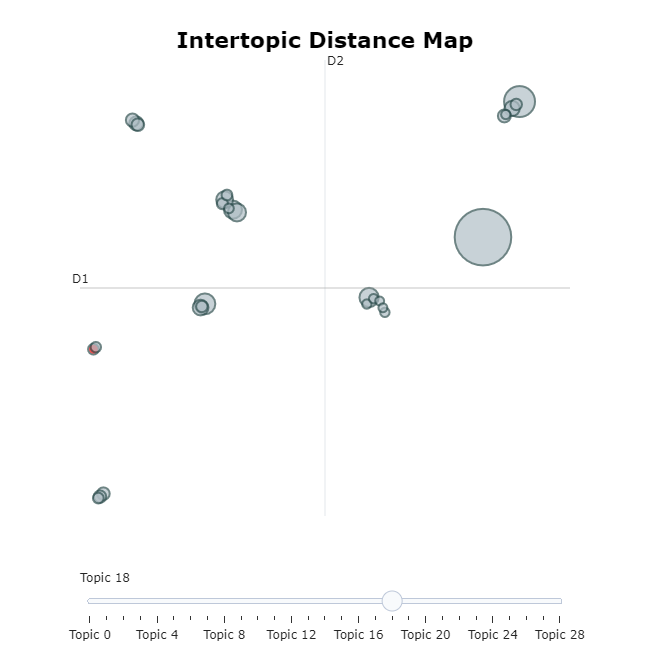

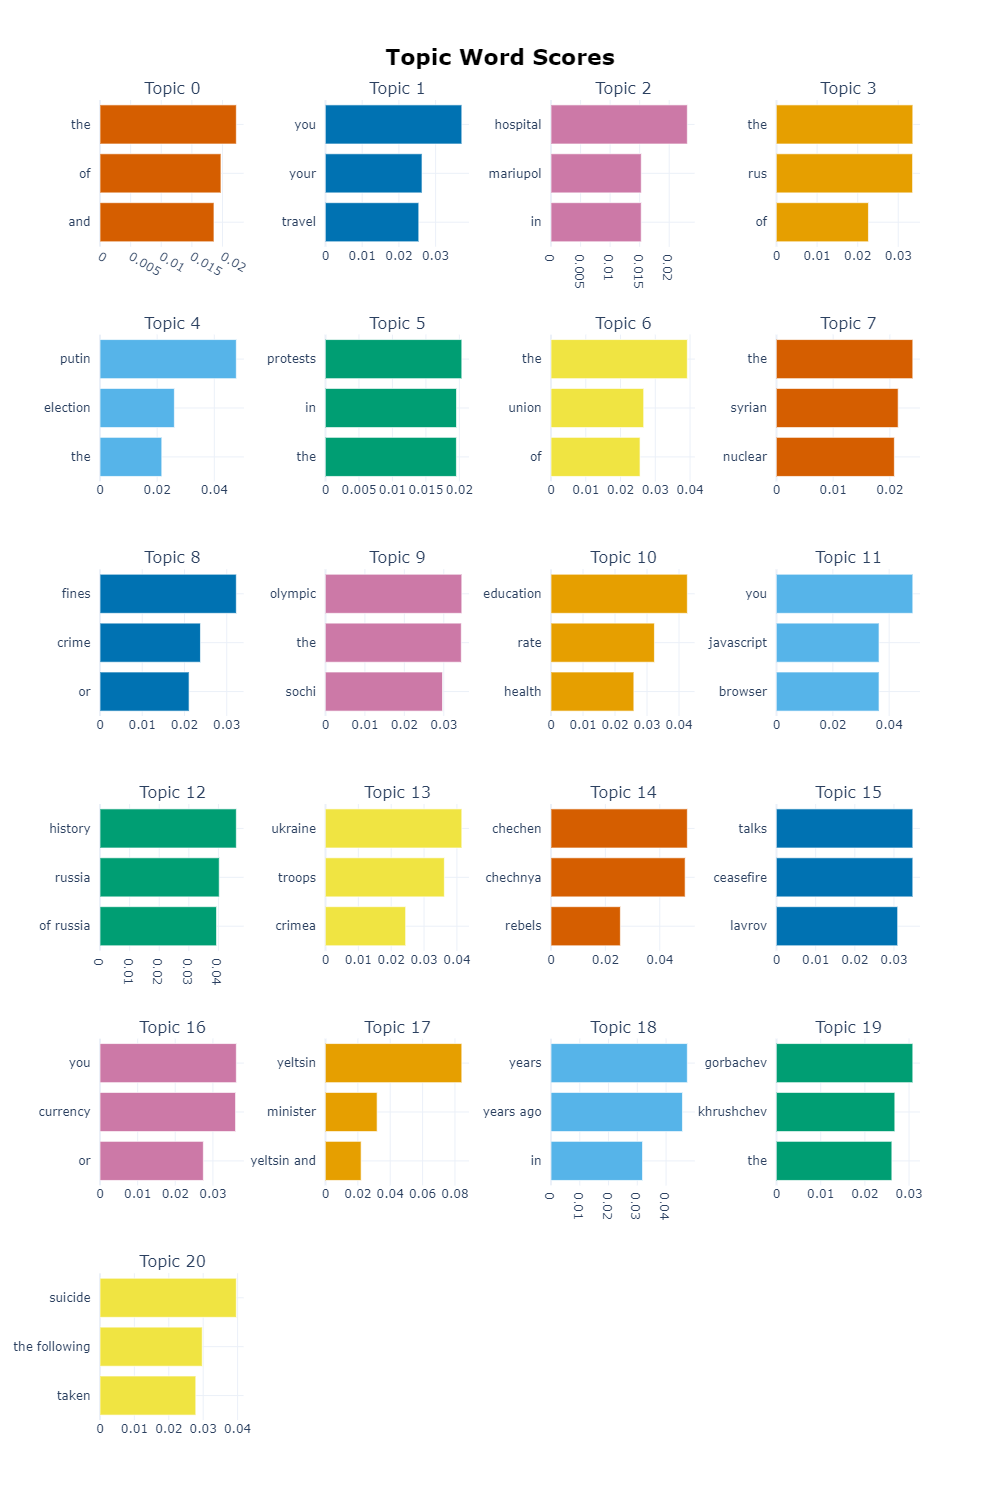